In [1]:
import math
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import itertools
from scipy import stats

# Read Datasets

### Covid-19 Dataset - [Kings, New York, Queens] counties of NY state

In [2]:
# Read CSV
covid_19_df = pd.read_csv(".\\comb_nyc_covid_19_45_days.csv")

# Convert Dates to pd.DateTime
covid_19_df['Dates'] = pd.to_datetime(covid_19_df['Dates'], format="%m/%d/%Y")

# Sort by County and Dates
covid_19_df = covid_19_df.sort_values(by=['County', 'Dates'])

# Shape of the Covid-19 Dataset
print(covid_19_df.shape)

covid_19_df.head()

(135, 5)


,Dates,County,Confirmed_Cases,Confirmed_Deaths,Hospitalized
0,2020-03-24,Kings,4407,42,637
3,2020-03-25,Kings,5232,64,919
6,2020-03-26,Kings,6095,81,968
9,2020-03-27,Kings,7091,102,989
12,2020-03-28,Kings,8129,167,1372


### X Dataset - 311 service requests - [Kings, New York, Queens] counties of NY state

In [3]:
# Combined Dataset for X

# Read CSVs
X_19_df = pd.read_csv(".\\sr_311_stats_mar_may_19.csv")
X_20_df = pd.read_csv(".\\sr_311_stats_mar_may_20.csv")

# Convert Dates to pd.DateTime
X_19_df['Dates'] = pd.to_datetime(X_19_df['Dates'])
X_20_df['Dates'] = pd.to_datetime(X_20_df['Dates'])


# Sort by Dates
X_19_df = X_19_df.sort_values(by=['Dates'])
X_20_df = X_20_df.sort_values(by=['Dates'])

# Shape of the X-19 & X-20 Dataset
print(X_19_df.shape, X_20_df.shape)

(44, 4) (44, 4)


In [4]:
X_19_df.head()

,Dates,Service Requests,Residential Noise Complaints,Parking Complaints
0,2019-03-25,6442,326,751
1,2019-03-26,6154,312,704
2,2019-03-27,6185,289,759
3,2019-03-28,5821,324,777
4,2019-03-29,5842,445,768


# Data Cleaning

In [15]:
counties = ["Kings", "New York", "Queens"]
covid_feature_columns = ["Confirmed_Cases", "Confirmed_Deaths", "Hospitalized"]
x_feature_columns = ["Service Requests", "Residential Noise Complaints", "Parking Complaints"]

#### Covid-19 Dataset

#### Convert cummulative data to accumulative data for [Confirmed_Cases, Confirmed_Deaths] columns of Covid-19 dataset

In [6]:
# Converting from cummulative data to daily increase
def get_daily_numbers(A):
    B = [0] + A.copy()[:-1]
    return [0] + [A[i] - B[i] for i in range(1, len(A))]

conf_cases_daily_list = []
conf_deaths_daily_list = []
for county in counties:
    sub_df = covid_19_df[covid_19_df["County"]==county]
    conf_cases_daily_list.extend(get_daily_numbers(sub_df["Confirmed_Cases"].tolist()))
    conf_deaths_daily_list.extend(get_daily_numbers(sub_df["Confirmed_Deaths"].tolist()))
covid_19_df['Confirmed_Cases'] = conf_cases_daily_list
covid_19_df['Confirmed_Deaths'] = conf_deaths_daily_list

# Remove the initial date since it's daily increase is unkown
covid_19_df.drop(covid_19_df[covid_19_df['Dates'] == "2020-03-24"].index, inplace = True)

# Print the shape
covid_19_df.shape

(132, 5)

### Outlier Detection - Tukey's Rule

In [14]:
def get_outliers(df, alpha, feature_columns):
    iqr_cols = []
    for col in feature_columns:
        X = df[col].tolist()
        X.sort()
        Q1 = int(X[math.ceil((25/100)*len(X)) - 1])
        Q3 = int(X[math.ceil((75/100)*len(X)) - 1])
        IQR = Q3 - Q1
        df[col + "_is_outlier"] = df[col].apply(lambda ele: (ele > Q3 + alpha * IQR) or (ele < Q1 - alpha * IQR))
        iqr_cols.append(col + "_is_outlier")
    outlier_vals = df[iqr_cols].any(axis='columns').tolist()
    print("Percentage of outliers: ", (sum([1 for bool in outlier_vals if bool])/len(outlier_vals))*100)
    return outlier_vals

#### Covid-19 Dataset

In [23]:
is_outlier_list = []
alpha_value = {
    "Kings" : 1.6,
    "New York" : 1.5,
    "Queens" : 1.5
}
for county in counties:
    print("County: ", county)
    is_outlier_list.extend(get_outliers(covid_19_df[covid_19_df["County"]==county].copy(), alpha_value[county], covid_feature_columns))
covid_19_df["is_outlier"] = is_outlier_list

print("\nOutliers are: ")
covid_19_df[covid_19_df.is_outlier == True]

County:  Kings
Percentage of outliers:  4.545454545454546
County:  New York
Percentage of outliers:  4.545454545454546
County:  Queens
Percentage of outliers:  4.545454545454546

Outliers are: 


,Dates,County,Confirmed_Cases,Confirmed_Deaths,Hospitalized,is_outlier
45,2020-04-08,Kings,1345,239,5114,True
66,2020-04-15,Kings,2029,235,7968,True
46,2020-04-08,New York,608,113,2809,True
67,2020-04-15,New York,1351,156,4090,True
44,2020-04-07,Queens,1726,253,6078,True
53,2020-04-10,Queens,1995,266,8637,True


##### X Dataset

In [24]:
X_19_df["is_outlier"] = get_outliers(X_19_df.copy(), 1.5, x_feature_columns)

print("Outliers are: ")
X_19_df[X_19_df.is_outlier == True]

Percentage of outliers:  2.272727272727273
Outliers are: 


,Dates,Service Requests,Residential Noise Complaints,Parking Complaints,is_outlier
31,2019-04-25,5267,309,473,True


In [25]:
X_20_df["is_outlier"] = get_outliers(X_20_df.copy(), 2.0, x_feature_columns)

print("Outliers are: ")
X_19_df[X_20_df.is_outlier == True]

Percentage of outliers:  4.545454545454546
Outliers are: 


,Dates,Service Requests,Residential Noise Complaints,Parking Complaints,is_outlier
38,2019-05-02,6213,356,818,False
39,2019-05-03,6421,412,871,False


In [26]:
# Replacing the outliers with zero
filtered_covid_19_df = covid_19_df[covid_19_df.is_outlier == False]
filtered_covid_19_df = filtered_covid_19_df.drop(columns=["is_outlier"])
X_19_df = X_19_df.drop(columns=["is_outlier"])
X_20_df = X_20_df.drop(columns=["is_outlier"])
filtered_covid_19_df.shape, X_19_df.shape, X_20_df.shape

((126, 5), (44, 4), (44, 4))

In [27]:
# combining data
filtered_covid_19_df = covid_19_df.copy()
filtered_covid_19_df = filtered_covid_19_df.groupby(["Dates"], as_index = False).sum()
filtered_covid_19_df.shape

(44, 5)

In [28]:
filtered_covid_19_df.tail()

,Dates,Confirmed_Cases,Confirmed_Deaths,Hospitalized,is_outlier
39,2020-05-03,1247,155,31110,0.0
40,2020-05-04,856,117,31349,0.0
41,2020-05-05,1134,156,31561,0.0
42,2020-05-06,1061,174,31590,0.0
43,2020-05-07,1035,175,31716,0.0


# Visualizing the Data

### Covid-19 Dataset & X Dataset Visualizations

#### Line Plot

<Figure size 432x288 with 0 Axes>

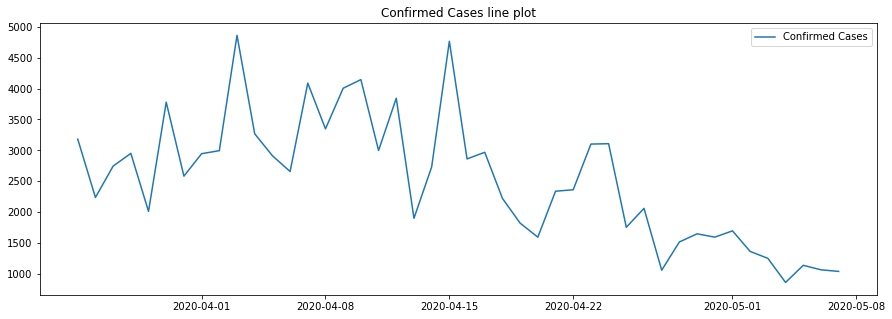

In [77]:
plt.clf()
plt.figure(figsize=(15, 5))
plt.title('Confirmed Cases line plot')
plt.plot(filtered_covid_19_df.Dates, filtered_covid_19_df.Confirmed_Cases ,label='Confirmed Cases')
plt.legendb(loc="best")
plt.show()

##### Observations:
The daily cases were up in the initial 2 weeks and post reaching the peak, the daily cases have been dropping.

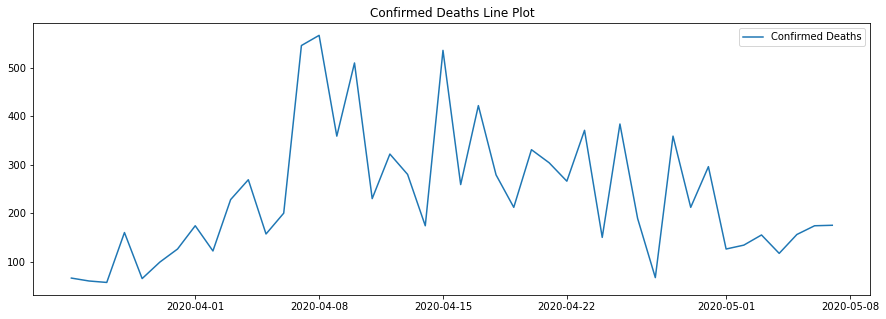

In [78]:
plt.figure(figsize=(15, 5))
plt.title('Confirmed Deaths Line Plot')
plt.plot(filtered_covid_19_df.Dates, filtered_covid_19_df.Confirmed_Deaths ,label='Confirmed Deaths')
plt.legend(loc="best")
plt.show()

##### Observations:
The daily deaths rose pretty slow initially, but over the period of 2-3 weeks the daily deaths were pretty high and now there's decrease in daily deaths. Indicating that the region is post peak.

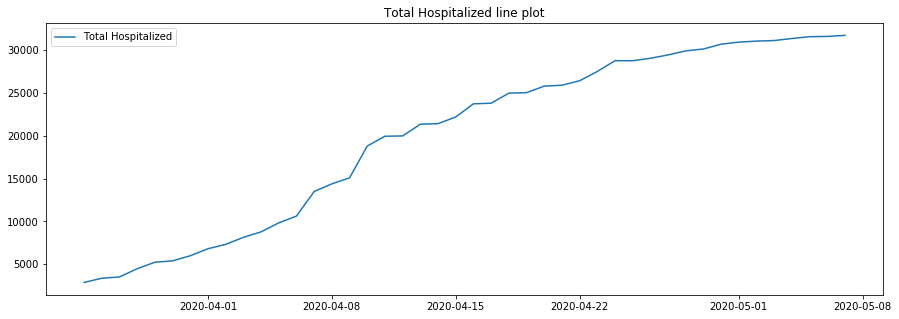

In [79]:
plt.figure(figsize=(15, 5))
plt.title('Total Hospitalized line plot')
plt.plot(filtered_covid_19_df.Dates, filtered_covid_19_df.Hospitalized ,label='Total Hospitalized')
plt.legend(loc="best")
plt.show()

##### Observations:
Since the data is total hospitalized on particular date and there's no information on discharged, the hospitalized patients have been increasing even though the daily cases have been dropping. This says much about the severity of the cases have been increasing. 

#### Bar Plot

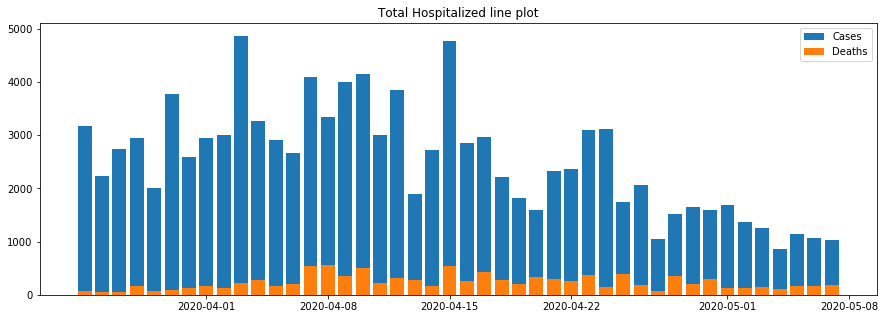

In [81]:
plt.figure(figsize=(15, 5))
plt.title('Total Hospitalized line plot')
plt.bar(filtered_covid_19_df.Dates, filtered_covid_19_df.Confirmed_Cases ,label='Cases')
plt.bar(filtered_covid_19_df.Dates, filtered_covid_19_df.Confirmed_Deaths ,label='Deaths')
plt.legend(loc="best")
plt.show()

##### Observations
1. Here we can see the percentage of deaths being very less compared to the dailiy cases.
2. The daily cases are decreasing, but the daily deaths have been consistently getting higher percentage of the daily cases.

#### Histogram Plot

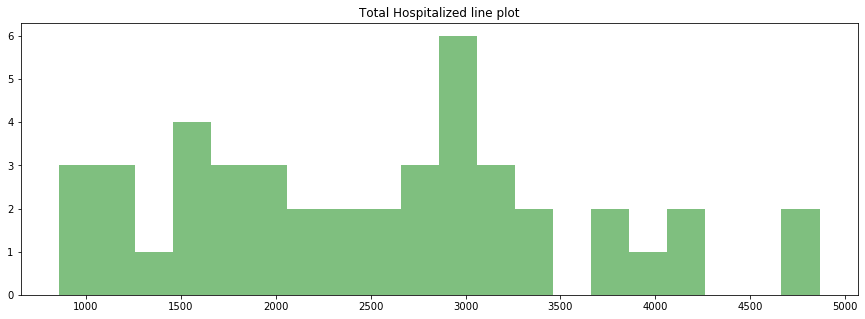

In [89]:
plt.figure(figsize=(15, 5))
plt.title('Total Hospitalized line plot')
plt.hist(filtered_covid_19_df.Confirmed_Cases, 20, facecolor='green', alpha=0.5)
plt.show()

<Figure size 432x288 with 0 Axes>

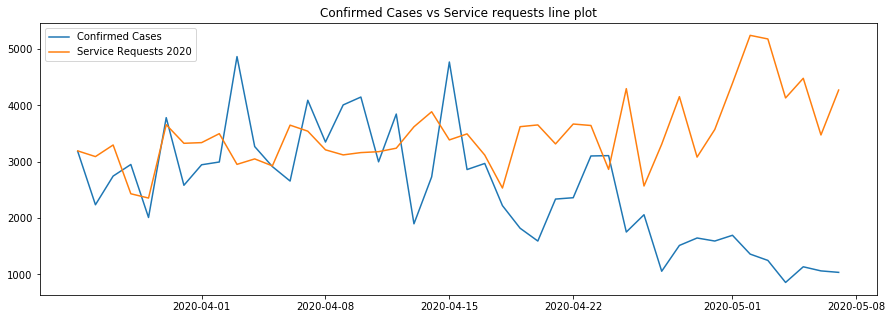

In [102]:
plt.clf()
plt.figure(figsize=(15, 5))
plt.title('Confirmed Cases vs Service requests line plot')
plt.plot(filtered_covid_19_df.Dates, filtered_covid_19_df.Confirmed_Cases ,label='Confirmed Cases')
plt.plot(X_20_df.Dates, X_20_df["Service Requests"] ,label='Service Requests 2020')
plt.legend(loc="best")
plt.show()

##### Observations:
1. We can see the the servuce reuests increasing as the cases started dropping.

<Figure size 432x288 with 0 Axes>

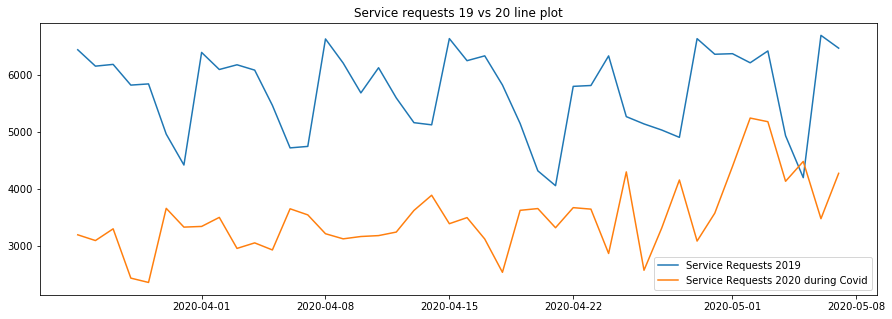

In [105]:
plt.clf()
plt.figure(figsize=(15, 5))
plt.title('Service requests 19 vs 20 line plot')
plt.plot(X_20_df.Dates, X_19_df["Service Requests"] ,label='Service Requests 2019')
plt.plot(X_20_df.Dates, X_20_df["Service Requests"] ,label='Service Requests 2020 during Covid')
plt.legend(loc="best")
plt.show()

##### Observations:
1. We can clearly see that the service requests during covid has decreased a lot compared to last year

# REQUIRED INFERENCES

## Inference 1

#### Helper Functions

##### EWMA

In [30]:
# Calculates the EWMA
def get_ewma(y_data, alpha):
    # For rolling predictions
    week_est = [y_data[0]]
    
    i = 1
    # Predicting for one week
    while(i <= 7):
        # ith day prediction is added to weekly estimates
        week_est.append(round((alpha * y_data[i - 1]) + (1 - alpha) * week_est[i - 1], 4))
        i += 1
    # returning last one week prediction data
    return week_est[1:8]

# Calculates the MSE
def mse(true_labels, preds):
    return round(sum([(true_labels[i] - preds[i])**2 for i in range(len(true_labels))])/len(true_labels), 4)

# Calculates the MAPE
def mape(true_labels, preds):
    return round(sum([(abs(true_labels[i] - preds[i])/true_labels[i])* 100 for i in range(len(true_labels))])/len(true_labels), 4)

##### AR

In [33]:
# Calculates the beta value using the OLS
def get_ar_beta_values(y_data, p):
    n = len(y_data)
    
    # Training Data X
    X = []
    for i in range(p, n):
        X.append([1] + [y_data[i - j] for j in list(range(1, p+1))[::-1]]) 
    X = np.array(X)
    
    # True Labels Y
    Y = np.asarray(y_data[p:])  
    
    # Performing the matrix operations to get (X_T * X)^-1 * X_T * Y
    X_T_X = np.matmul(np.transpose(X), X)
    
    # Temp 1 holds the value for (X_T * X)^-1
    temp1 = np.linalg.inv(X_T_X)
    
    # Temp 2 holds the value for X_T * Y
    temp2 = np.matmul(np.transpose(X), Y)
    
    # Final beta values including beta_0
    betas = np.matmul(temp1, temp2)
    
    return betas

# Predicts one week data using AR
def calc_ar_one_week(y_data, p):
    # To store AR estimates
    ar_est = []
    for i in range(7):
        # Calculate betas for every rolling prediction
        betas = get_ar_beta_values(y_data[:21+i], p)
        week_est = y_data[:21+i].copy()
        n = len(week_est)
        # Calculates the y_(21+i)_cap value
        ar_est.append(betas[0] + sum([betas[j + 1] * week_est[n-j-1] for j in range(p)]))
        
    # Rounding the estimates to 2 decimal places
    ar_est = [round(x, 2) for x in ar_est]
    
    return ar_est

In [34]:
# Predicting Cases
print("Predictions of Confirmed Cases\n")
four_weeks_cases_data = filtered_covid_19_df.Confirmed_Cases.tolist()[:28]

print("\n--Auto Regression--\n")
## AR with p = 3
preds = calc_ar_one_week(four_weeks_cases_data, 3)
print("Predicting next one week cases using AR with p = 3")
print(preds)
print("True values of next one week: ", four_weeks_cases_data[21:])
print("MSE: ", mse(four_weeks_cases_data[21:], preds))
print("MAPE: ", mape(four_weeks_cases_data[21:], preds))
print()

## AR with p = 5
preds = calc_ar_one_week(four_weeks_cases_data, 5)
print("Predicting next one week cases using AR with p = 5")
print(preds)
print("True values of next one week: ", four_weeks_cases_data[21:])
print("MSE: ", mse(four_weeks_cases_data[21:], preds))
print("MAPE: ", mape(four_weeks_cases_data[21:], preds))
print()

print("--EWMA--\n")
## EWMA with alpha = 0.5
preds = get_ewma(four_weeks_cases_data[:21], 0.5)
print("Predicting next one week cases using EWMA with alpha = 0.5")
print(preds)
print("True values of next one week: ", four_weeks_cases_data[21:])
print("MSE: ", mse(four_weeks_cases_data[21:], preds))
print("MAPE: ", mape(four_weeks_cases_data[21:], preds))
print()

## EWMA with alpha = 0.8
preds = get_ewma(four_weeks_cases_data[:21], 0.8)
print("Predicting next one week cases using EWMA with alpha = 0.8")
print(preds)
print("True values of next one week: ", four_weeks_cases_data[21:])
print("MSE: ", mse(four_weeks_cases_data[21:], preds))
print("MAPE: ", mape(four_weeks_cases_data[21:], preds))

Predictions of Confirmed Cases


--Auto Regression--

Predicting next one week cases using AR with p = 3
[3064.45, 3521.66, 3268.41, 3064.89, 3363.53, 3227.01, 2865.57]
True values of next one week:  [4769, 2860, 2968, 2220, 1818, 1591, 2336]
MSE:  1356143.7177
MAPE:  45.3669

Predicting next one week cases using AR with p = 5
[3099.86, 3686.42, 3463.07, 3633.26, 3049.84, 3046.88, 3328.7]
True values of next one week:  [4769, 2860, 2968, 2220, 1818, 1591, 2336]
MSE:  1476266.5912
MAPE:  49.4282

--EWMA--

Predicting next one week cases using EWMA with alpha = 0.5
[3181.0, 2708.0, 2726.0, 2838.0, 2423.5, 3102.25, 2841.625]
True values of next one week:  [4769, 2860, 2968, 2220, 1818, 1591, 2336]
MSE:  841642.779
MAPE:  32.0775

Predicting next one week cases using EWMA with alpha = 0.8
[3181.0, 2424.2, 2680.04, 2896.008, 2186.4016, 3462.0803, 2757.2161]
True values of next one week:  [4769, 2860, 2968, 2220, 1818, 1591, 2336]
MSE:  1009379.6641
MAPE:  34.9413


In [35]:
# Predicting Deaths
print("Predictions of Confirmed Deaths\n")
four_weeks_deaths_data = filtered_covid_19_df.Confirmed_Deaths.tolist()[:28]

## AR with p = 3
preds = calc_ar_one_week(four_weeks_deaths_data, 3)
print("Predicting next one week deaths using AR with p = 3")
print(preds)
print("True values of next one week: ", four_weeks_deaths_data[21:])
print("MSE: ", mse(four_weeks_deaths_data[21:], preds))
print("MAPE: ", mape(four_weeks_deaths_data[21:], preds))
print()

## AR with p = 5
preds = calc_ar_one_week(four_weeks_deaths_data, 5)
print("Predicting next one week deaths using AR with p = 5")
print(preds)
print("True values of next one week: ", four_weeks_deaths_data[21:])
print("MSE: ", mse(four_weeks_deaths_data[21:], preds))
print("MAPE: ", mape(four_weeks_deaths_data[21:], preds))
print()

## EWMA with alpha = 0.5
preds = get_ewma(four_weeks_deaths_data[:21], 0.5)
print("Predicting next one week deaths using EWMA with alpha = 0.5")
print(preds)
print("True values of next one week: ", four_weeks_deaths_data[21:])
print("MSE: ", mse(four_weeks_deaths_data[21:], preds))
print("MAPE: ", mape(four_weeks_deaths_data[21:], preds))
print()

## EWMA with alpha = 0.8
preds = get_ewma(four_weeks_deaths_data[:21], 0.8)
print("Predicting next one week deaths using EWMA with alpha = 0.8")
print(preds)
print("True values of next one week: ", four_weeks_deaths_data[21:])
print("MSE: ", mse(four_weeks_deaths_data[21:], preds))
print("MAPE: ", mape(four_weeks_deaths_data[21:], preds))

Predictions of Confirmed Deaths

Predicting next one week deaths using AR with p = 3
[281.56, 352.52, 310.15, 369.37, 333.35, 306.08, 279.57]
True values of next one week:  [536, 259, 422, 279, 212, 331, 304]
MSE:  15729.5025
MAPE:  30.7542

Predicting next one week deaths using AR with p = 5
[398.59, 397.72, 179.32, 386.68, 297.41, 351.83, 355.15]
True values of next one week:  [536, 259, 422, 279, 212, 331, 304]
MSE:  16994.0558
MAPE:  34.1007

Predicting next one week deaths using EWMA with alpha = 0.5
[66.0, 63.0, 60.0, 110.0, 87.5, 93.25, 109.625]
True values of next one week:  [536, 259, 422, 279, 212, 331, 304]
MSE:  75532.5647
MAPE:  72.0302

Predicting next one week deaths using EWMA with alpha = 0.8
[66.0, 61.2, 57.84, 139.568, 79.9136, 95.1827, 119.8365]
True values of next one week:  [536, 259, 422, 279, 212, 331, 304]
MSE:  74150.2056
MAPE:  70.6365


## Inference 2

#### Helper Functions

##### Wald's Test

###### One - Sample

In [36]:
# Calculates one-sample wald's statistics value
def get_one_sample_walds(x_data, theta_o):
    
    # Calculates the sample mean of X
    mean_est_x = sum(x_data)/len(x_data)
    
    # Calculating the sample variance of X
    var_mle_est_x = (sum([(x - mean_est_x)**2 for x in x_data])/len(x_data))
    
    # Calculating the sample standard error of X
    se_est = math.sqrt((var_mle_est_x/len(x_data)))
    
    # Value of |W|
    W = abs((mean_est_x - theta_o)/ se_est)
    
    return W

###### Two - Sample

In [37]:
# Calculates two-sample wald's statistics value
def get_two_sample_walds(x_data, y_data):
    
    # Calculates the sample mean of X & Y
    mean_est_x = sum(x_data)/len(x_data)
    mean_est_y = sum(y_data)/len(y_data)
    
    # Calculating the sample variance of X & Y
    var_mle_est_x = (sum([(x - mean_est_x)**2 for x in x_data])/len(x_data))
    var_mle_est_y = (sum([(y - mean_est_y)**2 for y in y_data])/len(y_data))
    
    # Calculating the sample standard error of X & Y
    se_est = math.sqrt((var_mle_est_x/len(x_data)) + (var_mle_est_y/len(y_data)))
    
    # Value of |W|
    W = abs((mean_est_x - mean_est_y)/(se_est))
    
    return W

##### One - Sample t-test

In [38]:
# Calculates One-sample t statistics value
def get_one_sample_t_value(x_data, mu_o):
    
    # Calculates the sample mean of X
    mean_est_x = sum(x_data)/len(x_data)
    
    # Calculating the sample variance of X
    var_mle_est_x = (sum([(x - mean_est_x)**2 for x in x_data])/len(x_data))
    
    denominator = math.sqrt(var_mle_est_x/len(x_data) - 1)
    
    # Value of |t|
    return abs((mean_est_x - mu_o)/denominator)

###### Paired t-test

In [39]:
# Calculates two-sample paired t statistics value
def get_paired_t_test(x_data, y_data):
    D = [x_data[i] - y_data[i] for i in range(len(x_data))]
    
    # Calculates the sample mean of X & Y
    mean_est_x = sum(x_data)/len(x_data)
    mean_est_y = sum(y_data)/len(y_data)
    
    mean_est_D = mean_est_x - mean_est_y
    
    # Calculating the sample variance of X & Y
    var_mle_est_x = (sum([(x - mean_est_x)**2 for x in x_data])/len(x_data) - 1)
    var_mle_est_y = (sum([(y - mean_est_y)**2 for y in y_data])/len(y_data) - 1)
    
    denominator = math.sqrt(var_mle_est_x/len(D))
    
    # Value of |t|
    return abs(mean_est_D/denominator)

###### Unpaired t-test

In [40]:
# Calculates two-sample unpaired t statistics value
def get_unpaired_t_test(x_data, y_data):
    
    # Calculates the sample mean of X & Y
    mean_est_x = sum(x_data)/len(x_data)
    mean_est_y = sum(y_data)/len(y_data)
    
    mean_est_D = mean_est_x - mean_est_y
    
    # Calculating the sample variance of X & Y
    var_mle_est_x = (sum([(x - mean_est_x)**2 for x in x_data])/(len(x_data) - 1))
    var_mle_est_y = (sum([(y - mean_est_y)**2 for y in y_data])/(len(y_data) - 1))
    
    denominator = math.sqrt((var_mle_est_x / len(x_data)) + (var_mle_est_y / len(y_data)))
    
    # Value of |t|
    return abs(mean_est_D/denominator)

##### Z-test

In [41]:
# Calculates One-sample z statistics value
def get_one_sample_z_value(x_data, mu_o, true_std_dev):
    
    # Calculates the sample mean of X
    mean_est_x = sum(x_data)/len(x_data)
    
    denominator = true_std_dev/math.sqrt(len(x_data))
    
    # Value of |z|
    return abs((mean_est_x - mu_o)/denominator)

In [42]:
# Calculated the sample std dev of X
def get_sample_std_dev(x_data):
    
    # Calculates the sample mean of X
    mean_est_x = sum(x_data)/len(x_data)
    
    # Calculating the sample variance of X
    var_mle_est_x = (sum([(x - mean_est_x)**2 for x in x_data])/(len(x_data) - 1))
    
    return math.sqrt(var_mle_est_x)

# Gives result of hypothesis using test statistic and threshold - for t-test, z-test, wald's
def hypothesis_test(test_statistic, threshold):
    # TODO
    if test_statistic <= threshold:
        return "Reject Null Hypothesis"
    else:
        return "Accept Null Hypothesis"

In [43]:
second_last_week_data_cases = filtered_covid_19_df.Confirmed_Cases.tolist()[30:37]
second_last_week_data_deaths = filtered_covid_19_df.Confirmed_Deaths.tolist()[30:37]

sl_cases_mean = np.mean(second_last_week_data_cases)
sl_deaths_mean = np.mean(second_last_week_data_deaths)

last_week_data_cases = filtered_covid_19_df.Confirmed_Cases.tolist()[37:44]
last_week_data_deaths = filtered_covid_19_df.Confirmed_Deaths.tolist()[37:44]

### Hypothesis Declaration

In [44]:
# Hypothesis explained
print("--Hypothesis--")
print("Null Hypothesis -> H_0: mean of X != mean of Y")
print("Alternative Hypothesis -> H_1: mean of X = mean of Y")

--Hypothesis--
Null Hypothesis -> H_0: mean of X != mean of Y
Alternative Hypothesis -> H_1: mean of X = mean of Y


In [45]:
# thresholds
z_alpha_over_2 = 1.96 # for alpha = 0.05
t_n_1_alpha_over_2 = 2.447 # for n = 7 and alpha = 0.05

In [46]:
# One Sample Tests - to check whether the mean of COVID19 #deaths and #cases are different from the second-last week to the last week in the dataset

print("--One Sample Wald's test--\n")
one_sample_w_val_cases = get_one_sample_walds(last_week_data_cases, sl_cases_mean)
print("Value of |W| for last week cases  : ", one_sample_w_val_cases)
print("Hypothesis Result: ", hypothesis_test(one_sample_w_val_cases, z_alpha_over_2))
print()

one_sample_w_val_deaths = get_one_sample_walds(last_week_data_deaths, sl_deaths_mean)
print("Value of |W| for last week deaths  : ", one_sample_w_val_deaths)
print("Hypothesis Result: ", hypothesis_test(one_sample_w_val_deaths, z_alpha_over_2))

print("\n--One Sample t-test--\n")
one_sample_t_val_cases = get_one_sample_t_value(last_week_data_cases, sl_cases_mean)
print("Value of |t| for last week cases  : ", one_sample_t_val_cases)
print("Hypothesis Result: ", hypothesis_test(one_sample_t_val_cases, t_n_1_alpha_over_2))
print()

one_sample_t_val_deaths = get_one_sample_t_value(last_week_data_deaths, sl_deaths_mean)
print("Value of |t| for last week deaths  : ", one_sample_t_val_deaths)
print("Hypothesis Result: ", hypothesis_test(one_sample_t_val_deaths, t_n_1_alpha_over_2))

print("\n--One Sample z-test--\n")
true_std_dev_cases = get_sample_std_dev(filtered_covid_19_df.Confirmed_Cases.tolist())
one_sample_z_val_cases = get_one_sample_z_value(last_week_data_cases, sl_cases_mean, true_std_dev_cases)
print("Value of |z| for last week cases  : ", one_sample_z_val_cases)
print("Hypothesis Result: ", hypothesis_test(one_sample_z_val_cases, z_alpha_over_2))
print()

true_std_dev_deaths = get_sample_std_dev(filtered_covid_19_df.Confirmed_Deaths.tolist())
one_sample_z_val_deaths = get_one_sample_z_value(last_week_data_deaths, sl_deaths_mean, true_std_dev_deaths)
print("Value of |z| for last week deaths  : ", one_sample_z_val_deaths)
print("Hypothesis Result: ", hypothesis_test(one_sample_z_val_deaths, z_alpha_over_2))

--One Sample Wald's test--

Value of |W| for last week cases  :  6.537154018741871
Hypothesis Result:  Accept Null Hypothesis

Value of |W| for last week deaths  :  11.031300028481647
Hypothesis Result:  Accept Null Hypothesis

--One Sample t-test--

Value of |t| for last week cases  :  6.537518260999364
Hypothesis Result:  Accept Null Hypothesis

Value of |t| for last week deaths  :  11.117866883148983
Hypothesis Result:  Accept Null Hypothesis

--One Sample z-test--

Value of |z| for last week cases  :  1.5929006040095843
Hypothesis Result:  Reject Null Hypothesis

Value of |z| for last week deaths  :  1.7297320713680915
Hypothesis Result:  Reject Null Hypothesis


In [74]:
last_week_data_deaths, second_last_week_data_deaths

([117, 126, 134, 155, 156, 174, 175], [67, 150, 189, 212, 296, 359, 384])

In [47]:
print("--Two Sample Wald's test--\n")
two_sample_w_val_cases = get_two_sample_walds(second_last_week_data_cases, last_week_data_cases)
print("Value of |W| for last week cases  : ", two_sample_w_val_cases)
print("Hypothesis Result: ", hypothesis_test(two_sample_w_val_cases, z_alpha_over_2))
print()

two_sample_w_val_deaths = get_two_sample_walds(second_last_week_data_deaths, last_week_data_deaths)
print("Value of |W| for last week deaths  : ", two_sample_w_val_deaths)
print("Hypothesis Result: ", hypothesis_test(two_sample_w_val_deaths, z_alpha_over_2))

print("\n--Two Sample unpaired t test--\n")
two_sample_unpaired_t_val_cases = get_unpaired_t_test(second_last_week_data_cases, last_week_data_cases)
print("Value of unpaired |t| for last week cases  : ", two_sample_unpaired_t_val_cases)
print("Hypothesis Result: ", hypothesis_test(two_sample_unpaired_t_val_cases, t_n_1_alpha_over_2))
print()

two_sample_unpaired_t_val_deaths = get_unpaired_t_test(second_last_week_data_deaths, last_week_data_deaths)
print("Value of unpaired |t| for last week deaths  : ", two_sample_unpaired_t_val_deaths)
print("Hypothesis Result: ", hypothesis_test(two_sample_unpaired_t_val_deaths, t_n_1_alpha_over_2))

print("\n--Two Sample paired t test--\n")
two_sample_paired_t_val_cases = get_paired_t_test(second_last_week_data_cases, last_week_data_cases)
print("Value of paired |t| for last week cases  : ", two_sample_paired_t_val_cases)
print("Hypothesis Result: ", hypothesis_test(two_sample_paired_t_val_cases, t_n_1_alpha_over_2))
print()

two_sample_paired_t_val_deaths = get_paired_t_test(second_last_week_data_deaths, last_week_data_deaths)
print("Value of paired |t| for last week deaths  : ", two_sample_paired_t_val_deaths)
print("Hypothesis Result: ", hypothesis_test(two_sample_paired_t_val_deaths, t_n_1_alpha_over_2))

--Two Sample Wald's test--

Value of |W| for last week cases  :  2.5368661207992957
Hypothesis Result:  Accept Null Hypothesis

Value of |W| for last week deaths  :  2.1581668391426776
Hypothesis Result:  Accept Null Hypothesis

--Two Sample unpaired t test--

Value of unpaired |t| for last week cases  :  2.3486816450680092
Hypothesis Result:  Reject Null Hypothesis

Value of unpaired |t| for last week deaths  :  1.998074238340886
Hypothesis Result:  Reject Null Hypothesis

--Two Sample paired t test--

Value of paired |t| for last week cases  :  2.752589096131289
Hypothesis Result:  Accept Null Hypothesis

Value of paired |t| for last week deaths  :  2.2007907025734355
Hypothesis Result:  Reject Null Hypothesis


#### Assumptions and validity of tests
1. Wald's test (One-sample and Two-sample) are applicable since the our data (theta_cap) is AN and it also satisfies the CI range with z_alpha_over_2 as 1.96
2. Z-test is not applicable since the n is too small and we dunno the true std dev. And the test is rejecting the null hypothesis.
3. One sample t-test is applicable, since we dunno the true std dev and n is small. And our data (theta_cap) is AN.
4. Two sample paired t-test is applicable for the number of cases of covid-19 since there is dependency, but for deaths there is no dependency and hence the paired t-test is not applicable for number of deaths.
5. Two sample unpaired t-test is not applicable for the number of cases of covid-19 since there is dependency, but for deaths there is no dependency and hence the unpaired t-test is applicable for number of deaths.

## Inference 3

##### Helper Functions

In [48]:
# Calculates the e_CDF
def get_e_cdf_val(x, alpha):
    return sum([1 for x_i in x if x_i <= alpha])/len(x)

# Calculates the e_CDF-
def get_e_cdf_val_neg(x, e_cdf, y):
    e_cdf_neg = []
    for alpha in y:
        if min(x) >= alpha:
            e_cdf_neg.append(0)
        elif max(x)<alpha:
            e_cdf_neg.append(1)
        else:
            e_cdf_neg.append( e_cdf[len([y_i for y_i in x if y_i < alpha]) - 1])
    return e_cdf_neg

# Calculates the e_CDF+
def get_e_cdf_val_pos(x, e_cdf, y):
    e_cdf_pos = []
    for alpha in y:
        if min(x) > alpha:
            e_cdf_pos.append(0)
        elif max(x)<=alpha:
            e_cdf_pos.append(1)
        else:
            e_cdf_pos.append(e_cdf[len(e_cdf) - len([y_i for y_i in x if y_i > alpha]) - 1 ])
    return e_cdf_pos

# Calculates the CDF of poisson distribution
def poisson_cdf(lambda_mme, n):
    return sum([np.exp(-1 * lambda_mme) * (lambda_mme**i)/np.math.factorial(i) for i in range(n)])

# Calculates the CDF of geometric distribution
def geometric_cdf(p_mme, n):
    return 1 - (1 - p)**(n+1)

# Calculates n_C_r value
def comb(n,r):
    fact = math.factorial
    return fact(n)/(fact(r) * fact(n-r))

# Calculates the CDF of binomial distribution
def binomial_cdf(p_mme, n, k):
    return sum([comb(n, k) * (p_mme**i)*((1-p_mme)**(n-i)) for i in range(k)])

##### K-S Test

In [97]:
# Returns the k-s test hypothesis result using max_diff and threshold
def k_s_test_hyp_res(max_diff, threshold):
    # Since the Null Hypothesis given in the problem statement is alternative hypotheis in the original test,
    # we have handled this by changing the equality sign
    if max_diff <= threshold:
        return "Reject Null Hypothesis"
    else:
        return "Null Hypothesis is True"
    
def k_s_test_hyp_orig(max_diff, threshold):
    if max_diff > threshold:
        return "Reject Null Hypothesis"
    else:
        return "Null Hypothesis is True"

###### One-Sample Test

In [50]:
# One sample k-s test which handles for poisson, geometric & binomial
def one_sample_k_s_test(distribution_name, x, old_data): 
    
    # Sort the data
    x.sort()
    
    # Calculates the e_CDF of X
    cdf_x_val = [get_e_cdf_val(x, alpha) for alpha in x]
    
    # Calculates the parameters estimated on old data using MME
    # Calculates the Fy(X) for selected distribution
    Fy_x = []
    if distribution_name == "Poisson":
        lambda_mme = np.mean(old_data)
        Fy_x.extend([stats.poisson.cdf(i, lambda_mme) for i in range(len(x))])
    elif distribution_name == "Geometric":
        p_mme = 1/(np.mean(old_data) + 1)
        Fy_x.extend([stats.geom.cdf(i, p_mme) for i in range(len(x))])
    elif distribution_name == "Binomial":
        p_mme = np.mean(old_data)/len(old_data)
        Fy_x.extend([stats.binom.cdf(i, len(x), p_mme) for i in range(1, len(x)+1)])

    # Calculates the Fx(X) + and -
    Fx_hat_x_neg = get_e_cdf_val_neg(x, cdf_x_val, x)
    Fx_hat_x_pos = get_e_cdf_val_pos(x, cdf_x_val, x)
    
    # Computes the max diff
    max_diff = 0
    plt_vals = []
    for i in range(len(x)):
        diff = abs(Fy_x[i] - Fx_hat_x_neg[i])
        if diff >= max_diff:
            max_diff = diff
        diff = abs(Fy_x[i] - Fx_hat_x_pos[i])
        if diff >= max_diff:
            max_diff = diff
    
    # Rounding the decimal places to 2
    max_diff = round(max_diff,2)
    
    return max_diff

###### Two-Sample Test

In [51]:
# Two-sample k-s test
def two_sample_k_s_test(x, y):
    
    # Sort both the data
    x.sort()
    y.sort()

    # Calculate eCDF of for both x and y
    cdf_x_val = [get_e_cdf_val(x, alpha) for alpha in x]
    cdf_y_val = [get_e_cdf_val(y, alpha) for alpha in y]
    
    # Fetch unique value of X and sort it again
    uniq_x = list(set(x))
    uniq_x.sort()
    
    # Calculate Fx(X), Fy(X)-, Fy(X)+
    Fx_hat_x = [get_e_cdf_val(y, alpha) for alpha in uniq_x]
    Fy_hat_x_neg = get_e_cdf_val_neg(x, cdf_x_val, uniq_x)
    Fy_hat_x_pos = get_e_cdf_val_pos(x, cdf_x_val, uniq_x)
    
    # Compute the max diff
    max_diff = 0
    plt_vals = []
    for i in range(len(uniq_x)):
        diff = abs(Fx_hat_x[i] - Fy_hat_x_neg[i])
        if diff >= max_diff:
            max_diff = diff
        diff = abs(Fx_hat_x[i] - Fy_hat_x_pos[i])
        if diff >= max_diff:
            max_diff = diff
    
    # Rounding the decimal places to 2
    max_diff = round(max_diff,2)
    
    return max_diff

###### Permutation Test

In [96]:
# Calculates the p_value by picking n random permutations from x+y
def get_p_value(x, y, n):
    
    # Calculates the t_observe
    t_obs = abs(np.mean(x) - np.mean(y))
    x_size = len(x)
    p_value = 0
    for i in range(n):
        # Fetches a random permutation
        perm  = np.random.permutation(x + y)
        
        # Comparing t_i with t_observe
        if (abs(np.mean(perm[0:x_size]) - np.mean(perm[x_size:]))) > t_obs:
            p_value += 1
    
    # Final p_value
    p_value /= n
    return p_value

# Gives the permutation test result based on p_value and threshold
def perumtation_test_res(p_val, threshold):
    # The equality sign is changed to opposite of the original. Since the null hypothesis is X not equal to Y
    # The rejection part of the distribution will be such that mean of X will be equal to mean of Y
    # H_0 = [X != Y]  vs H_1 = [X = Y]
    if p_val > threshold:
        return "Reject Null Hypothesis"
    else:
        return "Null Hypothesis is True"
    
def perumtation_test_orig(p_val, threshold):
    if p_val <= threshold:
        return "Reject Null Hypothesis"
    else:
        return "Null Hypothesis is True"

### Hypothesis Declaration

In [53]:
# Hypothesis explained
print("--Hypothesis--")
print("Null Hypothesis -> H_0: mean of X != mean of Y")
print("Alternative Hypothesis -> H_1: mean of X = mean of Y")

--Hypothesis--
Null Hypothesis -> H_0: mean of X != mean of Y
Alternative Hypothesis -> H_1: mean of X = mean of Y


In [54]:
# Thresholds
c = 0.05
alpha = 0.05

In [55]:
# Last week and second last week covid-19 data of cases and deaths 
second_last_week_data_cases = filtered_covid_19_df.Confirmed_Cases.tolist()[30:37]
second_last_week_data_deaths = filtered_covid_19_df.Confirmed_Deaths.tolist()[30:37]

last_week_data_cases = filtered_covid_19_df.Confirmed_Cases.tolist()[37:44]
last_week_data_deaths = filtered_covid_19_df.Confirmed_Deaths.tolist()[37:44]

In [56]:
print("--One Sample K-S Test--\n")

one_sample_k_s_max_diff_cases_bin = one_sample_k_s_test("Binomial", last_week_data_cases, second_last_week_data_cases)
print("Max Diff of cases for Binmoial distribution : ", one_sample_k_s_max_diff_cases_bin)
print("Hypothesis Result: ", k_s_test_hyp_res(one_sample_k_s_max_diff_cases_bin, c))
print()

one_sample_k_s_max_diff_cases_geo = one_sample_k_s_test("Geometric", last_week_data_cases, second_last_week_data_cases)
print("Max Diff of cases for Geometric distribution : ", one_sample_k_s_max_diff_cases_geo)
print("Hypothesis Result: ", k_s_test_hyp_res(one_sample_k_s_max_diff_cases_geo, c))
print()

one_sample_k_s_max_diff_cases_poi = one_sample_k_s_test("Poisson", last_week_data_cases, second_last_week_data_cases)
print("Max Diff of cases for Poisson distribution : ", one_sample_k_s_max_diff_cases_poi)
print("Hypothesis Result: ", k_s_test_hyp_res(one_sample_k_s_max_diff_cases_poi, c))
print()

one_sample_k_s_max_diff_deaths_bin = one_sample_k_s_test("Binomial", last_week_data_deaths, second_last_week_data_deaths)
print("Max Diff of deaths for Binmoial distribution : ", one_sample_k_s_max_diff_deaths_bin)
print("Hypothesis Result: ", k_s_test_hyp_res(one_sample_k_s_max_diff_deaths_bin, c))
print()

one_sample_k_s_max_diff_deaths_geo = one_sample_k_s_test("Geometric", last_week_data_deaths, second_last_week_data_deaths)
print("Max Diff of deaths for Geometric distribution : ", one_sample_k_s_max_diff_deaths_geo)
print("Hypothesis Result: ", k_s_test_hyp_res(one_sample_k_s_max_diff_deaths_geo, c))
print()

one_sample_k_s_max_diff_deaths_poi = one_sample_k_s_test("Poisson", last_week_data_deaths, second_last_week_data_deaths)
print("Max Diff of deaths for Poisson distribution : ", one_sample_k_s_max_diff_deaths_poi)
print("Hypothesis Result: ", k_s_test_hyp_res(one_sample_k_s_max_diff_deaths_poi, c))
print()

--One Sample K-S Test--

Max Diff of cases for Binmoial distribution :  0.14
Hypothesis Result:  Null Hypothesis is True

Max Diff of cases for Geometric distribution :  1.0
Hypothesis Result:  Null Hypothesis is True

Max Diff of cases for Poisson distribution :  1.0
Hypothesis Result:  Null Hypothesis is True

Max Diff of deaths for Binmoial distribution :  0.14
Hypothesis Result:  Null Hypothesis is True

Max Diff of deaths for Geometric distribution :  0.98
Hypothesis Result:  Null Hypothesis is True

Max Diff of deaths for Poisson distribution :  1.0
Hypothesis Result:  Null Hypothesis is True



In [58]:
print("--Two Sample K-S Test--\n")
two_sample_k_s_max_diff_cases = two_sample_k_s_test(second_last_week_data_cases, last_week_data_cases)
print("Max Diff of cases : ", two_sample_k_s_max_diff_cases)
print("Hypothesis Result: ", k_s_test_hyp_res(two_sample_k_s_max_diff_cases, c))
print()

two_sample_k_s_max_diff_deaths = two_sample_k_s_test(second_last_week_data_deaths, last_week_data_deaths)
print("Max Diff of deaths : ", two_sample_k_s_max_diff_deaths)
print("Hypothesis Result: ", k_s_test_hyp_res(two_sample_k_s_max_diff_deaths, c))

--Two Sample K-S Test--

Max Diff of cases :  0.71
Hypothesis Result:  Null Hypothesis is True

Max Diff of deaths :  0.71
Hypothesis Result:  Null Hypothesis is True


In [62]:
# Since the computation required to calculate all possible permutations of 2 weeks is more, we are taking 50000 random permutations.
print("--Permutation Test--\n")
p_val_cases = get_p_value(second_last_week_data_cases, last_week_data_cases, 50000)
print("P-Value for cases is : ", p_val_cases)
print("Hypothesis result : ", perumtation_test_res(p_val_cases, 0.05))
print()

p_val_deaths = get_p_value(second_last_week_data_deaths, last_week_data_deaths, 50000)
print("P-Value for deaths is : ", p_val_deaths)
print("Hypothesis result : ", perumtation_test_res(p_val_deaths, 0.05))

p_val_cases, p_val_deaths

--Permutation Test--

P-Value for cases is :  0.01868
Hypothesis result :  Null Hypothesis is True

P-Value for deaths is :  0.08036
Hypothesis result :  Reject Null Hypothesis


(0.01868, 0.08036)

#### Assumptions and validity of tests
1. K-S test (one-sample and two-sample) are applicable since there are no assumptions. 
2. Permutation test doesn not apply for cases since the cases are not iids.
3. Permutation test doesn not apply for deaths since the deaths are not iids.

## Inference 4

##### Helper Functions

##### Pearson Correlation

In [63]:
def get_pearson_correlation(X, Y):
    
    # Calculating mean of X, Y
    x_bar = np.mean(X)
    y_bar = np.mean(Y)
    
    # Calculates numerator of S_Cap_x,y formula
    nr = sum([(X[i] - x_bar)*(Y[i] - y_bar) for i in range(len(X))])
    
    # Calculates denominator of S_Cap_x,y formula
    dr = (sum([(X[i] - x_bar)**2 for i in range(len(X))]) * sum([(Y[i] - y_bar)**2 for i in range(len(X))]))**0.5
    
    return round(nr/dr, 4)

# Gives correlation based on the pearson correlation coefficient
def get_correlation(pearson_val):
    if pearson_val > 0.5:
        return "Positive Linear Correlation"
    elif pearson_val < -0.5:
        return "Negative Linear Correlation"
    else:
        return "No Correlation"

In [64]:
# Passing last 30 days data of covid-19 and X dataset relevant column
pearson_val_cases = get_pearson_correlation(filtered_covid_19_df.Confirmed_Cases.tolist()[-30:], X_20_df["Service Requests"].tolist()[-30:])
print("Pearson Correlation Coefficient for Covid-19 cases and X dataset 2020 service requests over last one month data is : ", pearson_val_cases)
print("Correlation: ", get_correlation(pearson_val_cases))
print()

pearson_val_deaths = get_pearson_correlation(filtered_covid_19_df.Confirmed_Deaths.tolist()[-30:], X_20_df["Service Requests"].tolist()[-30:])
print("Pearson Correlation Coefficient for Covid-19 deaths and X dataset 2020 service requests over last one month data is : ", pearson_val_deaths)
print("Correlation: ", get_correlation(pearson_val_deaths))

Pearson Correlation Coefficient for Covid-19 cases and X dataset 2020 service requests over last one month data is :  -0.51
Correlation:  Negative Linear Correlation

Pearson Correlation Coefficient for Covid-19 deaths and X dataset 2020 service requests over last one month data is :  -0.3275
Correlation:  No Correlation


## Infernce 5

#### Bayesian Inference
Calculating the posterior considering 
    - prior as exponential(1/beta)
    - data distribution as poisson(lambda)
lambda_mme = (1/beta) = sample_mean

MAP for posterior at the end of week 1  : 4
MAP for posterior at the end of week 2  : 8
MAP for posterior at the end of week 3  : 12
MAP for posterior at the end of week 4  : 15


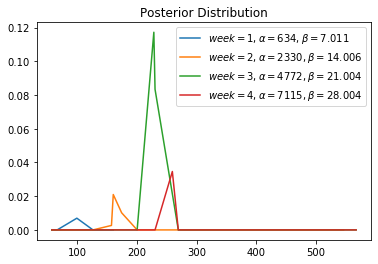

In [76]:
alphas = []
betas = []
weeks = 1
def get_posterior(x_data):
    global weeks
    sum_x = sum([(x_data[i]) for i in range(weeks * 7)])

    alpha = sum_x + 1
    beta = (weeks * 7) * (1 + (1 / sum_x))
    alphas.append(alpha)
    betas.append(beta)

    if weeks < 4:
        weeks += 1
        get_posterior(x_data)


def plot_posterior(x_data):
    get_posterior(x_data)

    for i in range(weeks):
        x = (x_data[: (i + 1) * 7])
        x.sort()
        y = stats.gamma.pdf(x, a=alphas[i], scale=1 / betas[i])
        plt.title("Posterior Distribution")
        plt.plot(x, y, label=(r'$ week = ' + str(i + 1) + ', \u03B1=' + str(alphas[i]) + ', \u03B2=' + str(round(betas[i], 3)) + '$'))
        plt.legend()
        print('MAP for posterior at the end of week', (i + 1), ' :', np.argmax(y))
    plt.show()
    

plot_posterior(four_weeks_deaths_data)

# NEW INFERENCES

## Inference 1

##### Description:
Using permutation test and k-s test to check whether the first two weeks of covid-19 data for #cases & #deaths and X data noise complaints follow same distribution. Through this test, we will know that once the cases arised, whether the noise complaints were also increasing or not.

In [66]:
# Data for the test
first_two_weeks_cases_data = filtered_covid_19_df.Confirmed_Cases.tolist()[:14]
first_two_weeks_deaths_data = filtered_covid_19_df.Confirmed_Deaths.tolist()[:14]
x_data_noise_complaints_data = X_20_df["Residential Noise Complaints"].tolist()[:14]

In [98]:
print("--Two Sample K-S Test--\n")
two_sample_k_s_max_diff_cases = two_sample_k_s_test(first_two_weeks_cases_data, x_data_noise_complaints_data)
print("Max Diff for cases is : ", two_sample_k_s_max_diff_cases)
print("Hypothesis result : ", k_s_test_hyp_orig(two_sample_k_s_max_diff_cases, 0.05))
print()

two_sample_k_s_max_diff_deaths = two_sample_k_s_test(first_two_weeks_deaths_data, x_data_noise_complaints_data)
print("Max Diff for cases is : ", two_sample_k_s_max_diff_deaths)
print("Hypothesis result : ", k_s_test_hyp_orig(two_sample_k_s_max_diff_deaths, 0.05))

--Two Sample K-S Test--

Max Diff for cases is :  1.0
Hypothesis result :  Reject Null Hypothesis

Max Diff for cases is :  0.93
Hypothesis result :  Reject Null Hypothesis


In [99]:
# Since the computation required to calculate all possible permutations of 2 weeks is more, we are taking 100000 random permutations.
print("--Permutation Test--\n")
p_val_cases = get_p_value(first_two_weeks_cases_data, x_data_noise_complaints_data, 100000)
print("P-Value for cases is : ", p_val_cases)
print("Hypothesis result : ", perumtation_test_orig(p_val_cases, 0.05))
print()

p_val_deaths = get_p_value(first_two_weeks_deaths_data, x_data_noise_complaints_data, 100000)
print("P-Value for deaths is : ", p_val_deaths)
print("Hypothesis result : ", perumtation_test_orig(p_val_deaths, 0.05))

--Permutation Test--

P-Value for cases is :  0.0
Hypothesis result :  Reject Null Hypothesis

P-Value for deaths is :  0.0
Hypothesis result :  Reject Null Hypothesis


##### Conclusions:
We can see that since the covid cases started rising, there was increase in noise complaints as well. We can infer that since the region was under lockdown and most of the people were at home, so there was surge in the complaints.

## Inference 2

##### Description: 
1. Effect of the decreasing daily cases on parking complaints. We can compare the covid cases of last two weeks with parking complaints
2. Computing the correlation of daily parking issues in 2019 and 2020. We can apply pearson correlation on first two weeks data to find the correlation between covid cases vs 2019 parking complaints and covid cases vs 2020 parking complaints.


In [69]:
# Data for the test - 1
last_two_weeks_cases_data = filtered_covid_19_df.Confirmed_Cases.tolist()[:20]
last_two_weeks_park_compl_data_20 = X_20_df["Parking Complaints"].tolist()[:20]

In [70]:
pearson_val_cases_20 = get_pearson_correlation(last_two_weeks_cases_data, last_two_weeks_park_compl_data_20)
print("Pearson Correlation Coefficient for Covid-19 deaths and X dataset 2020 parking complaints over first two weeks data is : ", pearson_val_cases_20)
print("Correlation: ", get_correlation(pearson_val_cases_20))

Pearson Correlation Coefficient for Covid-19 deaths and X dataset 2020 parking complaints over first two weeks data is :  -0.1774
Correlation:  No Correlation


In [71]:
# Data for the test - 2
cases_data = filtered_covid_19_df.Confirmed_Cases.tolist()
x_data_parking_complaints_data_19 = X_19_df["Parking Complaints"].tolist()
x_data_parking_complaints_data_20 = X_20_df["Parking Complaints"].tolist()

In [72]:
# Passing all 44 days data of covid-19 and X dataset relevant column
pearson_val_cases_19 = get_pearson_correlation(cases_data, x_data_parking_complaints_data_19)
print("Pearson Correlation Coefficient for Covid-19 cases and X dataset 2019 parking complaints over first two weeks data is : ", pearson_val_cases_19)
print("Correlation: ", get_correlation(pearson_val_cases_19))
print()

pearson_val_cases_20 = get_pearson_correlation(cases_data, x_data_parking_complaints_data_20)
print("Pearson Correlation Coefficient for Covid-19 deaths and X dataset 2020 parking complaints over first two weeks data is : ", pearson_val_cases_20)
print("Correlation: ", get_correlation(pearson_val_cases_20))

Pearson Correlation Coefficient for Covid-19 cases and X dataset 2019 parking complaints over first two weeks data is :  0.0738
Correlation:  No Correlation

Pearson Correlation Coefficient for Covid-19 deaths and X dataset 2020 parking complaints over first two weeks data is :  -0.6979
Correlation:  Negative Linear Correlation


##### Conclusions
We can see that the correlation between the cases and parking complaints are negative linear correlation. We can say that since the cases have been rising the people are staying home and have been decreasing since the lockdown is implemented.

## Inference 3

##### Description
Applying K-S test for pre-covid X data and covid X data. We will comapre the total service requests raised each day considering the absolute difference of the CDFs.

In [94]:
# Data for test
service_requests_19 = X_19_df["Service Requests"].tolist()
service_requests_20 = X_20_df["Service Requests"].tolist()

In [100]:
print("--Two Sample K-S Test--\n")
two_sample_k_s_max_diff_cases = two_sample_k_s_test(service_requests_19, service_requests_20)
print("Max Diff for service requests is : ", two_sample_k_s_max_diff_cases)
print("Hypothesis result : ", k_s_test_hyp_orig(two_sample_k_s_max_diff_cases, 0.05))

--Two Sample K-S Test--

Max Diff for service requests is :  0.86
Hypothesis result :  Reject Null Hypothesis


##### Conclusions
We can see that the k-s test rejects the null hypothesis. We can say that the covid had a huge impact on service requests.